In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('/content/merged_df.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


In [10]:
# 规范化数据
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 划分数据集
train_data = scaled_data[data.index < '2022-08-13']
test_data = scaled_data[data.index >= '2022-08-13']

# 准备数据集
def create_dataset(dataset, time_step=1, use_label=False):
    feature_columns = [0, 1] if use_label else [1]  # 当使用 'label' 时，选择两列
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), feature_columns]
        X.append(a)
        Y.append(dataset[i + time_step, 1])  # 目标值始终为 'close'
    return np.array(X), np.array(Y)


time_step = 30

# 单特征模型的数据
X_train_single, y_train_single = create_dataset(train_data, time_step, use_label=False)
X_test_single, y_test_single = create_dataset(test_data, time_step, use_label=False)

# 双特征模型的数据
X_train_double, y_train_double = create_dataset(train_data, time_step, use_label=True)
X_test_double, y_test_double = create_dataset(test_data, time_step, use_label=True)

# 查看数据形状
print("Shape of X_train_single:", X_train_single.shape)
print("Shape of X_test_single:", X_test_single.shape)
print("Shape of X_train_double:", X_train_double.shape)
print("Shape of X_test_double:", X_test_double.shape)

# 重塑为 LSTM 输入格式
X_train_single = X_train_single.reshape(X_train_single.shape[0], X_train_single.shape[1], 1)
X_test_single = X_test_single.reshape(X_test_single.shape[0], X_test_single.shape[1], 1)
X_train_double = X_train_double.reshape(X_train_double.shape[0], X_train_double.shape[1], 2)
X_test_double = X_test_double.reshape(X_test_double.shape[0], X_test_double.shape[1], 2)


# 构建和训练模型
def create_and_train_model(X_train, y_train):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)
    return model



Shape of X_train_single: (523, 30, 1)
Shape of X_test_single: (120, 30, 1)
Shape of X_train_double: (523, 30, 2)
Shape of X_test_double: (120, 30, 2)


In [11]:
# 训练两个模型
model_single = create_and_train_model(X_train_single, y_train_single)

Epoch 1/100
33/33 [==============================] - 6s 30ms/step - loss: 0.0383
Epoch 2/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0064
Epoch 3/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0050
Epoch 4/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0050
Epoch 5/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0040
Epoch 6/100
33/33 [==============================] - 1s 30ms/step - loss: 0.0038
Epoch 7/100
33/33 [==============================] - 1s 28ms/step - loss: 0.0035
Epoch 8/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0032
Epoch 9/100
33/33 [==============================] - 1s 28ms/step - loss: 0.0030
Epoch 10/100
33/33 [==============================] - 1s 31ms/step - loss: 0.0037
Epoch 11/100
33/33 [==============================] - 1s 44ms/step - loss: 0.0026
Epoch 12/100
33/33 [==============================] - 1s 42ms/step - loss: 0.0026
Epoch 13/100
33/33 [=====

In [12]:
model_double = create_and_train_model(X_train_double, y_train_double)

Epoch 1/100
33/33 [==============================] - 7s 40ms/step - loss: 0.0340
Epoch 2/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0060
Epoch 3/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0049
Epoch 4/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0046
Epoch 5/100
33/33 [==============================] - 1s 30ms/step - loss: 0.0044
Epoch 6/100
33/33 [==============================] - 1s 30ms/step - loss: 0.0040
Epoch 7/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0040
Epoch 8/100
33/33 [==============================] - 1s 30ms/step - loss: 0.0034
Epoch 9/100
33/33 [==============================] - 1s 31ms/step - loss: 0.0035
Epoch 10/100
33/33 [==============================] - 1s 45ms/step - loss: 0.0036
Epoch 11/100
33/33 [==============================] - 2s 49ms/step - loss: 0.0032
Epoch 12/100
33/33 [==============================] - 2s 46ms/step - loss: 0.0032
Epoch 13/100
33/33 [=====

4/4 [==============================] - 1s 13ms/step


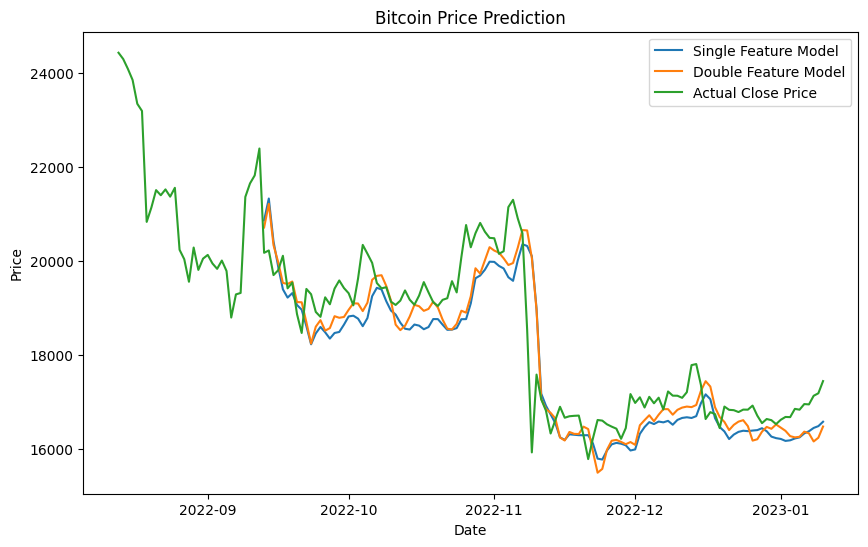

In [13]:
# 进行预测
def predict_and_inverse(model, X_test):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(np.column_stack((np.zeros(prediction.shape), prediction)))
    return prediction[:, 1]

prediction_single = predict_and_inverse(model_single, X_test_single)
prediction_double = predict_and_inverse(model_double, X_test_double)

# 绘制比较图
plt.figure(figsize=(10, 6))
plt.plot(data.index[len(data) - len(prediction_single):], prediction_single, label='Single Feature Model')
plt.plot(data.index[len(data) - len(prediction_double):], prediction_double, label='Double Feature Model')

# 根据您的数据结构调整此部分
# 如果是单特征模型，使用索引 0；如果是双特征模型，使用索引 1
index_for_actual = 0 if scaled_data.shape[1] == 1 else 1
plt.plot(data.index[len(data) - len(test_data):], scaler.inverse_transform(test_data)[:, index_for_actual], label='Actual Close Price')

plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error

# 获取测试数据的实际 close 值
# 根据您的数据结构调整此部分
index_for_actual = 0 if scaled_data.shape[1] == 1 else 1
actual_close = scaler.inverse_transform(test_data)[:, index_for_actual]

# 计算实际 close 值和模型预测值之间的 RMSE
rmse_single = np.sqrt(mean_squared_error(actual_close[len(actual_close) - len(prediction_single):], prediction_single))
rmse_double = np.sqrt(mean_squared_error(actual_close[len(actual_close) - len(prediction_double):], prediction_double))

print("RMSE for Single Feature Model:", rmse_single)
print("RMSE for Double Feature Model:", rmse_double)


RMSE for Single Feature Model: 812.350660559765
RMSE for Double Feature Model: 741.0587222247851
